In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import numpy as np

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import train_test_split

/Users/nimralatif/Desktop/Portfolio/Customer Churn Prediction System/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
%matplotlib inline
sns.set(style="whitegrid")

# 📌 Load the trained model
model = joblib.load("../models/best_model.pkl")

# 📌 Load and prepare the data
data = pd.read_csv("../data/processed_data.csv")
X = data.drop("Churn", axis=1)
y = data["Churn"]

# Make sure data used here matches the data used in training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

/var/folders/s8/3gktf4cx0z7cx_3npd6prb2c0000gn/T/ipykernel_24464/3071443811.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x="Importance", y="Feature", palette="viridis")


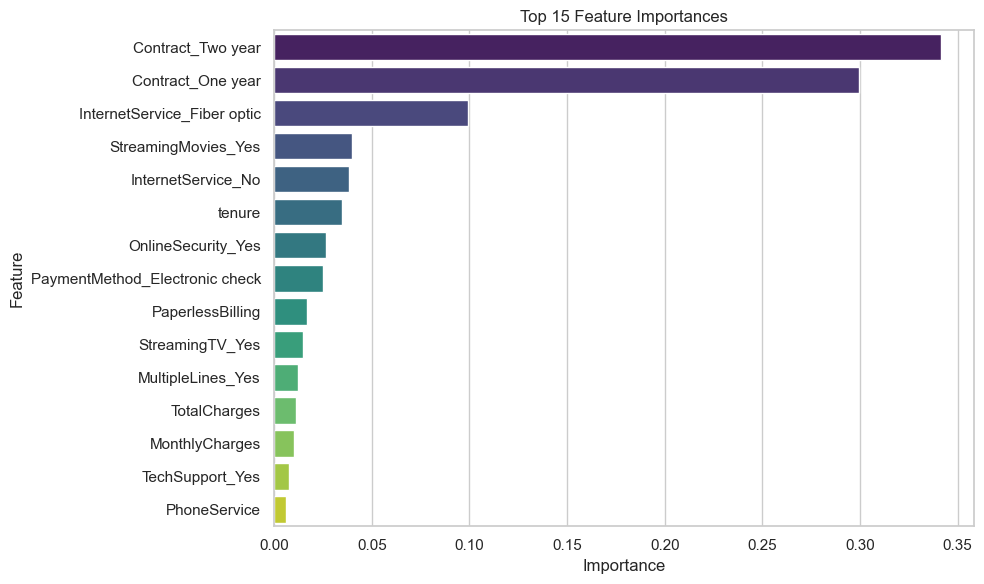

In [10]:
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x="Importance", y="Feature", palette="viridis")
    plt.title("Top 15 Feature Importances")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not support native feature_importances_. Consider using permutation_importance.")

🔄 Computing Permutation Importance...


/var/folders/s8/3gktf4cx0z7cx_3npd6prb2c0000gn/T/ipykernel_24464/1335997208.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_df.head(15), x="Importance", y="Feature", palette="coolwarm")


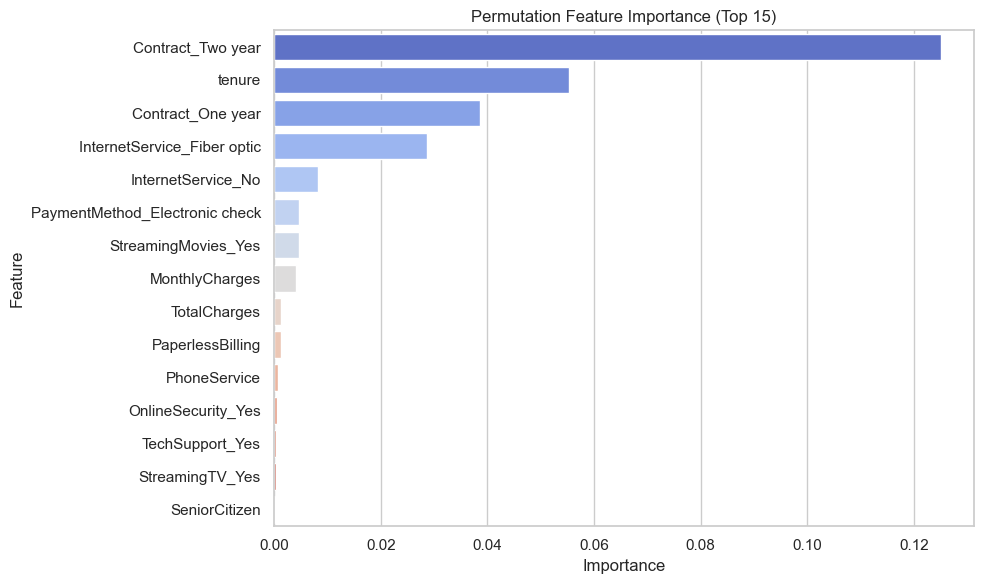

In [11]:

print("🔄 Computing Permutation Importance...")
perm_result = permutation_importance(model, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_result.importances_mean
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df.head(15), x="Importance", y="Feature", palette="coolwarm")
plt.title("Permutation Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

📈 SHAP Analysis...
❌ Found non-numeric columns: ['MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


 92%|==================  | 6510/7043 [00:11<00:00]       

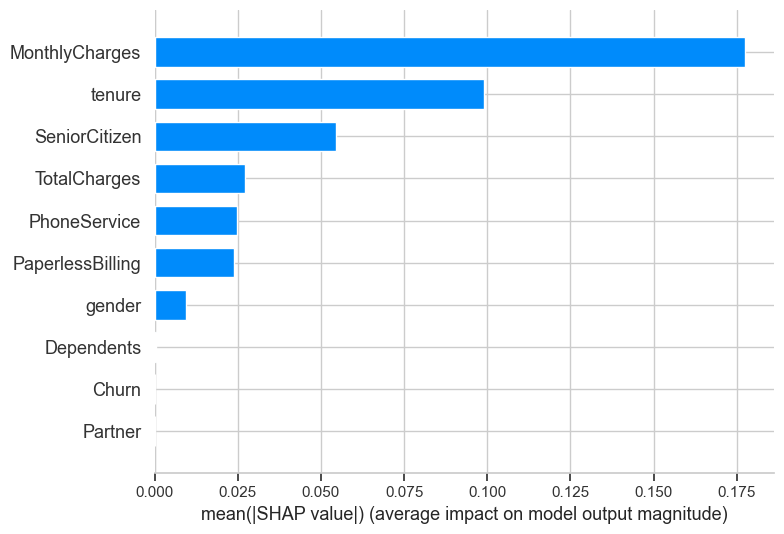

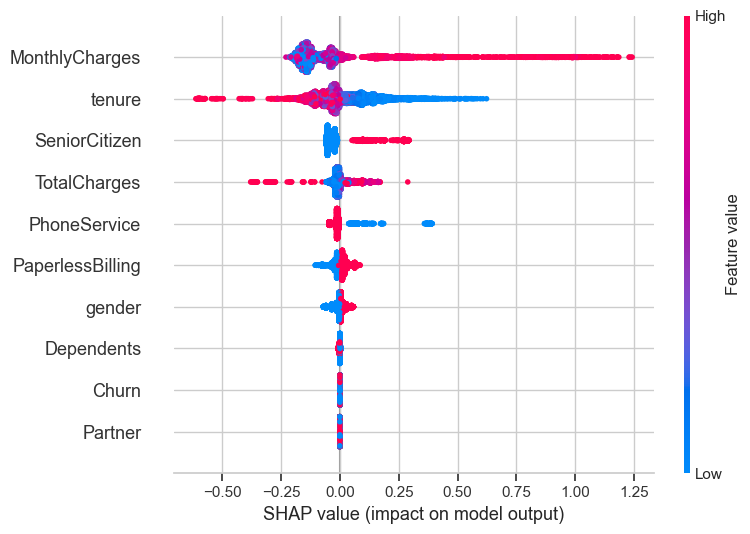

: 

In [8]:

print("📈 SHAP Analysis...")
df = pd.read_csv("../data/processed_data.csv")

if "churn" in df.columns:
    df = df.drop(columns=["churn"])
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

non_numeric_cols = df.select_dtypes(exclude=["number"]).columns
if len(non_numeric_cols) > 0:
    print(f"❌ Found non-numeric columns: {list(non_numeric_cols)}")
    df = df.drop(columns=non_numeric_cols) 

X_test = df.fillna(0)

explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test, check_additivity=False)


shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)

shap.summary_plot(shap_values, X_test, max_display=15)

sample_idx = 10
print(f"Explaining prediction for test instance at index {sample_idx}")
shap.plots.waterfall(shap_values[sample_idx], max_display=15)


In [ ]:
top_features = importance_df.head(3)["Feature"].tolist()


print("📊 Plotting Partial Dependence for top features...")
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(model, X_test, features=top_features, ax=ax)
plt.suptitle("Partial Dependence Plots", fontsize=16)
plt.tight_layout()
plt.show()